In [1]:
# Don't do this. Do as I say and not as I code.
import sys
sys.path.insert(0, "../") 

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import stan_utils as stan
from data_utils import (generate_data, test_data)
from mpl_utils import mpl_style

plt.style.use(mpl_style)

%matplotlib inline

In [2]:
seed = 42

data_kwds = dict(N=10000, D=10, J=3, K=2, seed=seed, full_output=True,
                 __cluster_mu_theta_scale=1, __cluster_sigma_theta_scale=1)
data, truths = generate_data(**data_kwds)

# generate a responsibility matrix that is more familiar.
responsibility_matrix = np.zeros((data_kwds["N"], data_kwds["K"]), dtype=float)
for k in range(data_kwds["K"]):
    responsibility_matrix[:, k] = (truths["responsibility"] == k).astype(int)

# Calculate the offsets (in data space) due to the clustering in factor scores
offset = np.dot(
    np.dot(responsibility_matrix, truths["cluster_mu_theta"]),
    truths["L"])
data["offset"] = -offset

In [3]:
print(data["offset"].shape)
for k in range(data_kwds["K"]):
    foo = data["offset"][truths["responsibility"] == k]
    assert np.allclose(foo[0], foo[-1])
    
    print(k, foo[0])
#data["offset"]


(10000, 10)
0 [ 0.27189731  0.41149669  0.7687106   0.73417685  0.219715    0.74544312
  0.65415572 -0.          0.41412388  0.41412388]
1 [-0.4630132  -1.17954532 -1.44001068 -1.46112394 -0.37415208 -1.53362944
 -1.11217153 -0.         -0.5436998  -0.5436998 ]


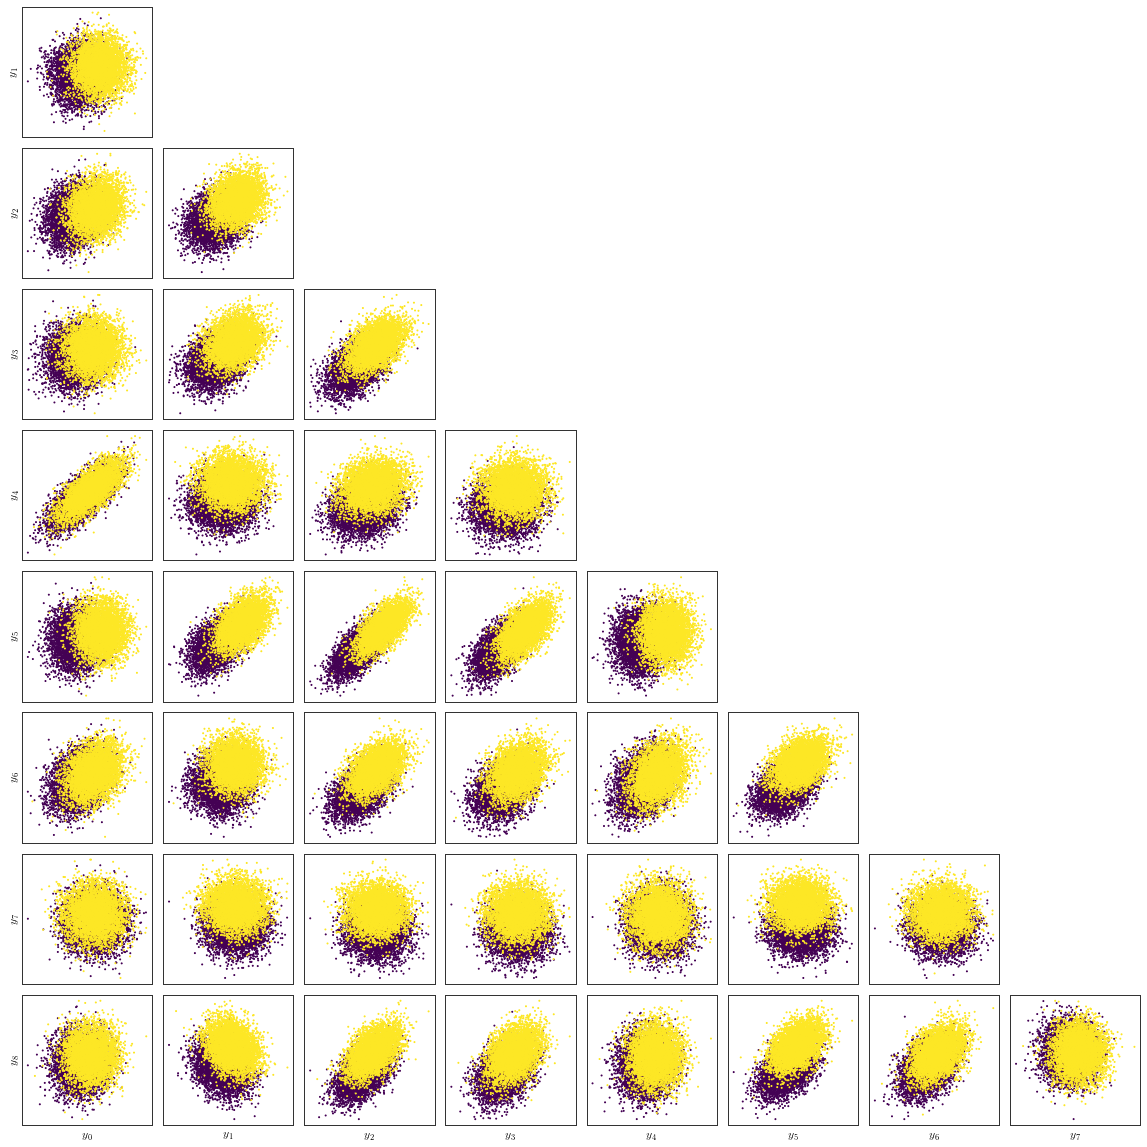

In [4]:
# Plot the data.
A = data["D"] - 1
fig, axes = plt.subplots(A, A, figsize=(2 * A, 2 * A))

ordered = True

y = data["y"]

c = truths["responsibility"]    
indices = np.argsort(c) if ordered else np.arange(len(c))
kwds = dict(s=1, alpha=1, c=c[indices])


for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        if j >= i:
            ax.set_visible(False)
            continue
            
        ax.scatter(y.T[i][indices], y.T[j][indices], **kwds)
        ax.set_xticks([])
        ax.set_yticks([])
        
        if ax.is_last_row():
            ax.set_xlabel(r"$y_{{{0}}}$".format(j))
        if ax.is_first_col():
            ax.set_ylabel(r"$y_{{{0}}}$".format(i))
    
fig.tight_layout()


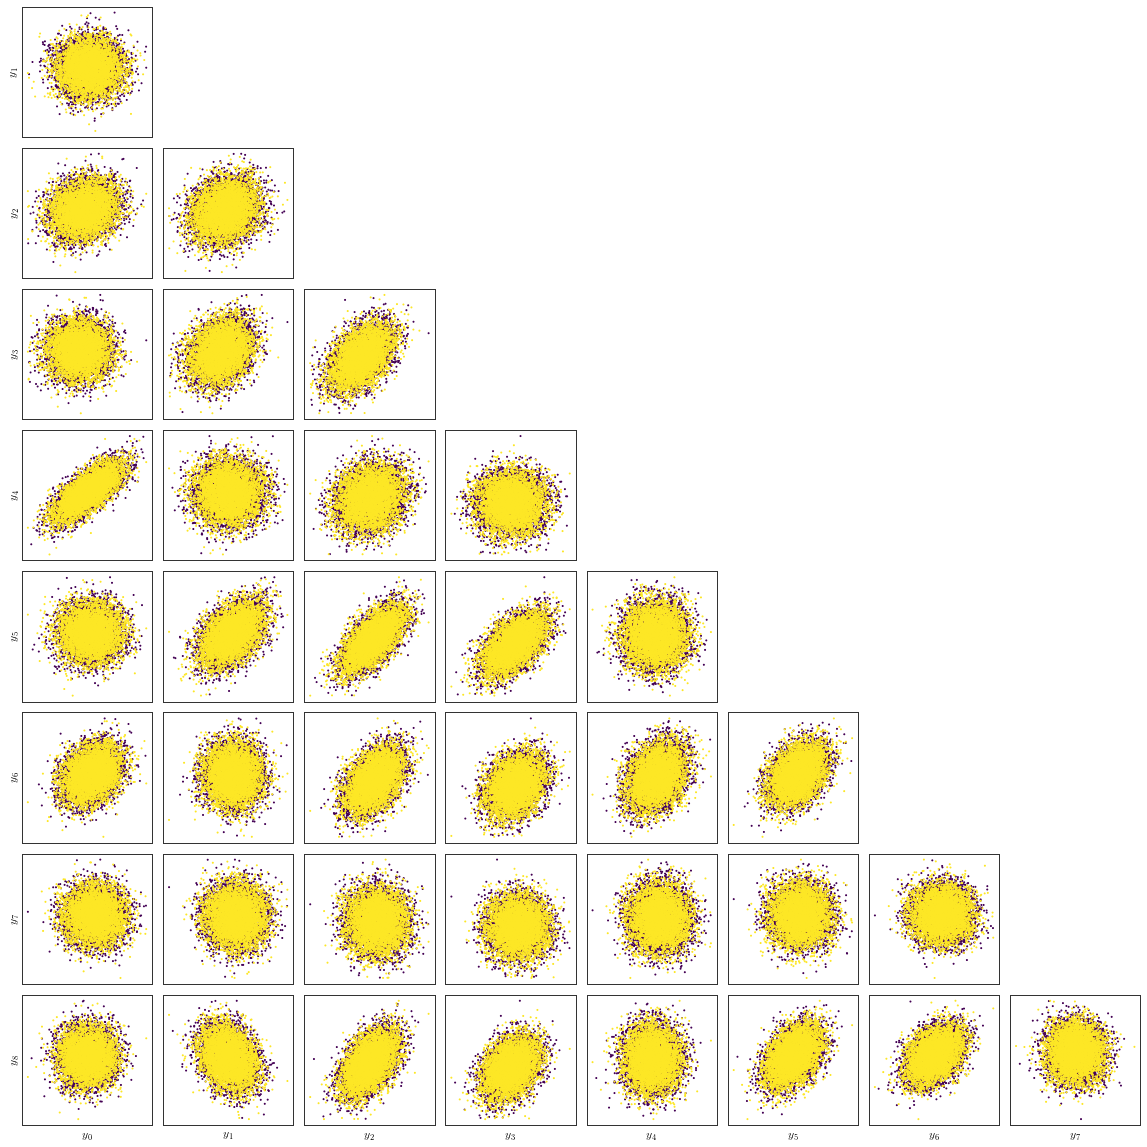

In [5]:
# Plot the data after subtracting the impact of the effect of clustering in  factor scores.
A = data["D"] - 1
fig, axes = plt.subplots(A, A, figsize=(2 * A, 2 * A))

ordered = True

y = data["y"]

c = truths["responsibility"]    
indices = np.argsort(c) if ordered else np.arange(len(c))
kwds = dict(s=1, alpha=1, c=c[indices])


for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        if j >= i:
            ax.set_visible(False)
            continue
            
        ax.scatter(y.T[i][indices] - offset.T[i][indices],
                   y.T[j][indices] - offset.T[j][indices], **kwds)
        ax.set_xticks([])
        ax.set_yticks([])
        
        if ax.is_last_row():
            ax.set_xlabel(r"$y_{{{0}}}$".format(j))
        if ax.is_first_col():
            ax.set_ylabel(r"$y_{{{0}}}$".format(i))
    
fig.tight_layout()


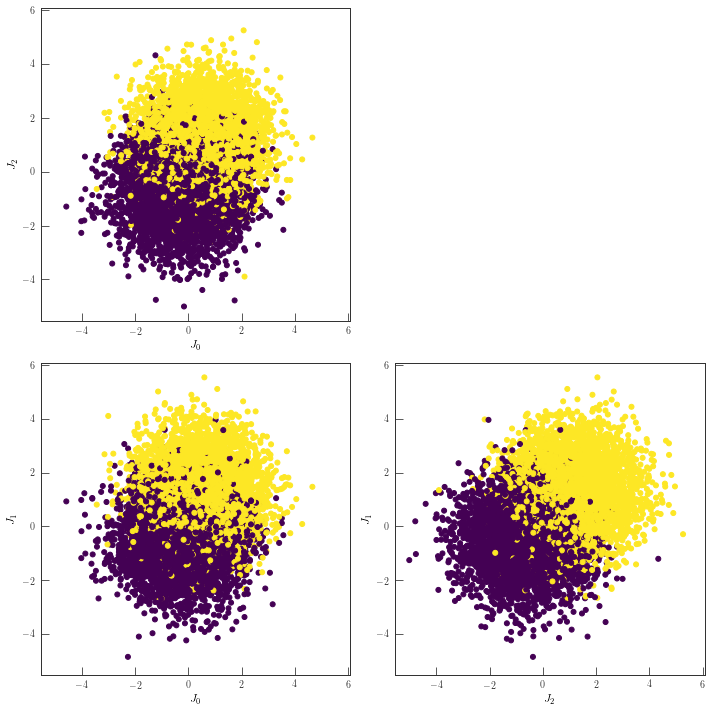

In [6]:
# Plot the factor scores
K = 2
fig, axes = plt.subplots(K, K, figsize=(10, 10))

axes[1, 0].scatter(truths["theta"].T[0], truths["theta"].T[1],
                   c=truths["responsibility"])
axes[1, 0].set_xlabel(r"$J_{{{0}}}$".format(0))
axes[1, 0].set_ylabel(r"$J_{{{0}}}$".format(1))

axes[0, 0].scatter(truths["theta"].T[0], truths["theta"].T[2],
                   c=truths["responsibility"])
axes[0, 0].set_xlabel(r"$J_{{{0}}}$".format(0))
axes[0, 0].set_ylabel(r"$J_{{{0}}}$".format(2))

axes[0, 1].set_visible(False)
axes[1, 1].scatter(truths["theta"].T[2], truths["theta"].T[1],
                   c=truths["responsibility"])
axes[1, 1].set_xlabel(r"$J_{{{0}}}$".format(2))
axes[1, 1].set_ylabel(r"$J_{{{0}}}$".format(1))

ax_flat = np.array(axes).flatten()
limits = np.array([[ax.get_xlim(), ax.get_ylim()] for ax in ax_flat])
limits = (np.min(limits), np.max(limits))

for ax in ax_flat:
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    
fig.tight_layout()


In [7]:
# Optimize
common_op_kwds = dict(
    init_alpha=1,
    tol_obj=1e-16, 
    tol_rel_obj=1e-16,
    tol_rel_grad=1e-16)

op_kwds = common_op_kwds.copy()
op_kwds.update(dict(data=data, seed=seed))

model = stan.load_stan_model("../mlf-clustered-given-offsets.stan")

s_opt = model.optimizing(**op_kwds)

INFO:root:Using pre-compiled model from ../mlf-clustered-given-offsets.stan.cached
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:362: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(np.asarray(v).dtype, int):
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [8]:
# Now re-run but set all offsets to zero.
data_no = data.copy()
data_no["offset"] = np.zeros_like(data_no["offset"])

# Optimize
op_no_kwds = common_op_kwds.copy()
op_no_kwds.update(dict(data=data_no, seed=seed))

model_no = stan.load_stan_model("../mlf-clustered-given-offsets.stan")

s_opt_no = model_no.optimizing(**op_no_kwds)

INFO:root:Using pre-compiled model from ../mlf-clustered-given-offsets.stan.cached
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:362: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(np.asarray(v).dtype, int):
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


(0.0520801674218368, 1.662376200571843)

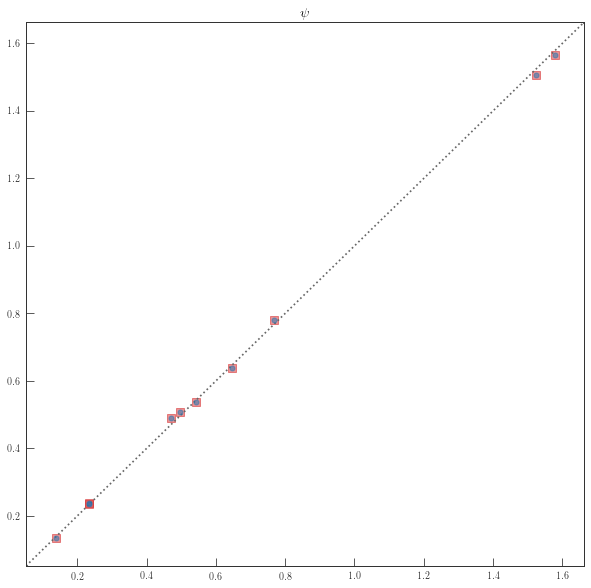

In [9]:
with_offset_kwds = dict(c="tab:blue", alpha=0.5)
without_offset_kwds = dict(c="tab:red", marker="s", zorder=-2, s=50, alpha=0.5)

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(np.diag(truths["psi"]), s_opt["psi"], **with_offset_kwds)
ax.scatter(np.diag(truths["psi"]), s_opt_no["psi"], **without_offset_kwds)
ax.set_title(r"$\psi$")
limits = np.hstack([ax.get_xlim(), ax.get_ylim()])
limits = np.array([limits.min(), limits.max()])
ax.plot(limits, limits, c="#666666", linestyle=":", zorder=-1)
ax.set_xlim(limits)
ax.set_ylim(limits)

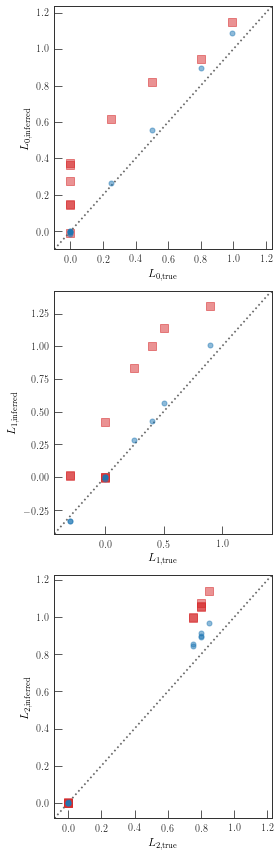

In [10]:
fig, axes = plt.subplots(truths["L"].shape[0], figsize=(4, 12))
for i, ax in enumerate(axes):
    ax.scatter(truths["L"][i], s_opt["L"].T[i], **with_offset_kwds)
    ax.scatter(truths["L"][i], s_opt_no["L"].T[i], **without_offset_kwds)

    limits = np.hstack([ax.get_xlim(), ax.get_ylim()])
    limits = np.array([limits.min(), limits.max()])
    ax.plot(limits, limits, c="#666666", linestyle=":", zorder=-1)
    ax.set_xlim(limits)
    ax.set_ylim(limits)

    ax.set_xlabel(r"$L_{{{0},\textrm{{true}}}}$".format(i))
    ax.set_ylabel(r"$L_{{{0},\textrm{{inferred}}}}$".format(i))

fig.tight_layout()

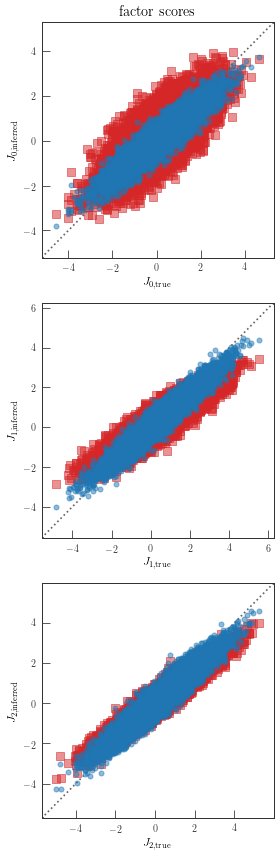

In [11]:
y = data["y"]
N, D = y.shape
N, J = truths["theta"].shape


factor_loads = s_opt["L"].T
b = factor_loads/np.sqrt(s_opt["psi"])
scaled_y = y/np.sqrt(s_opt["psi"])

b_sq = np.sum(b**2, axis=1)
factor_scores = np.dot(scaled_y, b.T) * (1 - J/(N - 1) * b_sq)/(1 + b_sq)



factor_loads_no = s_opt_no["L"].T
b_no = factor_loads_no/np.sqrt(s_opt_no["psi"])
scaled_y_no = y/np.sqrt(s_opt_no["psi"])

b_sq_no = np.sum(b_no**2, axis=1)
factor_scores_no = np.dot(scaled_y_no, b_no.T) * (1 - J/(N - 1) * b_sq_no)/(1 + b_sq_no)


fig, axes = plt.subplots(J, figsize=(4, 12))
for j, ax in enumerate(axes):
    ax.scatter(truths["theta"].T[j], factor_scores.T[j], **with_offset_kwds)
    ax.scatter(truths["theta"].T[j], factor_scores_no.T[j], **without_offset_kwds)

    limits = np.hstack([ax.get_xlim(), ax.get_ylim()])
    limits = np.array([np.min(limits), np.max(limits)])
    ax.plot(limits, limits, c="#666666", linestyle=":", zorder=-1)
    ax.set_xlim(limits)
    ax.set_ylim(limits)

    ax.set_xlabel(r"$J_{{{0},\textrm{{true}}}}$".format(j))
    ax.set_ylabel(r"$J_{{{0},\textrm{{inferred}}}}$".format(j))

axes[0].set_title(r"\textrm{factor scores}")
fig.tight_layout()
    

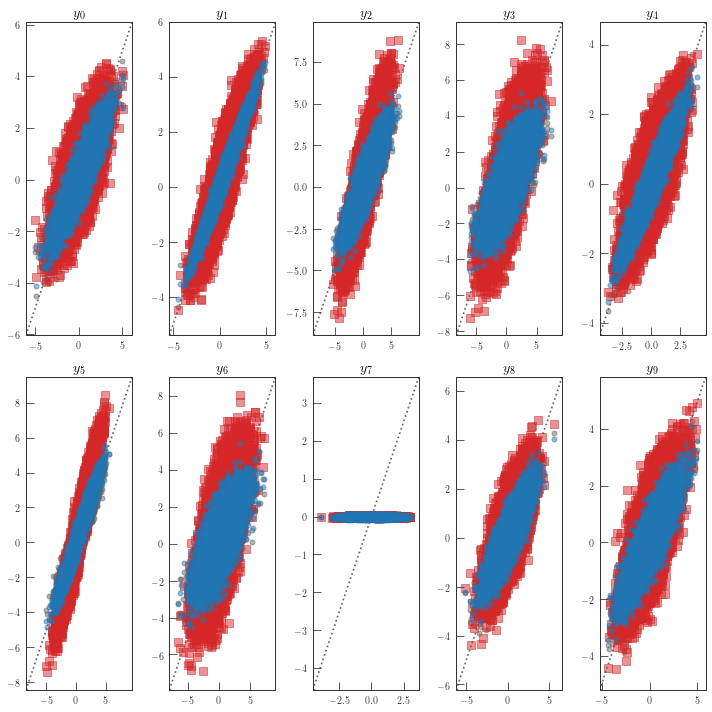

In [12]:
fig, axes = plt.subplots(2, 5, figsize=(10, 10))
axes = np.array(axes).flatten()

faux_y = np.dot(factor_scores, factor_loads)
faux_y_no = np.dot(factor_scores_no, factor_loads_no)
true_y = np.dot(truths["theta"], truths["L"])

for i, ax in enumerate(axes):
    ax.scatter(y.T[i], true_y.T[i], facecolor="#666666", zorder=-10, alpha=0.5)
    ax.scatter(y.T[i], faux_y.T[i], **with_offset_kwds)
    ax.scatter(y.T[i], faux_y_no.T[i], **without_offset_kwds)

    limits = np.hstack([ax.get_xlim(), ax.get_ylim()])
    limits = np.array([limits.min(), limits.max()])
    ax.plot(limits, limits, c="#666666", linestyle=":", zorder=-10)
    ax.set_xlim(limits)
    ax.set_ylim(limits)

    ax.set_title(r"$y_{{{0}}}$".format(i))
    
fig.tight_layout()
